In [592]:
import sys
sys.path.append('../build/')
%pylab inline
np.set_printoptions(precision=4, suppress=True)
import versor as vsr
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper')
from versor.drawing import *
from motor_estimation import MotorEstimationSolver
from game import VDMotorEstimationSolver
from icp import best_fit_transform
import pickle

Populating the interactive namespace from numpy and matplotlib


/Users/lars/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['log', 'inf', 'solve', 'Inf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Dataset generation

In [593]:
M_object_in_world = vsr.Vec(1.0,1.0,0.1).trs() * vsr.Biv(pi/4.0, 0.0,0.0).exp()
M_eye_in_hand = vsr.Vec(-0.1, -0.2, 0.3).trs() * (vsr.Biv(3.0,-1.0,4.0).unit() * (pi/9)).exp()
M_eye_in_hand_initial = vsr.Vec(0.11, 0.24, 0.36).trs() * (vsr.Biv(1.0,1.0,0.0).unit() * (np.pi/5.)).exp()

In [594]:
def hand_eye_pose_pairs(M_object_in_world, M_eye_in_hand, n):
    pose_pairs = [
            (M_hand_in_world, 
             (M_eye_in_hand.rev() * M_hand_in_world.rev() * M_object_in_world))
            for M_hand_in_world in [vsr.Vec(*np.random.rand(3)).trs() *
                                    vsr.Rot(vsr.Biv(*np.random.rand(3)).unit() *
                                            np.random.rand() * np.pi)
                                    for i in range(n)]]

    As = [pose_pair[0] for pose_pair in pose_pairs]
    Bs = [pose_pair[1] for pose_pair in pose_pairs]

    LAs = []
    LBs = []
    for i in range(n):
        for j in range(i+1,n):
            LAs.append(((As[j].rev() * As[i]).log() * 0.5).unit())
            LBs.append(((Bs[j] * Bs[i].rev()).log() * 0.5).unit())
    return LAs, LBs

In [595]:
n_lines = 10
lines_a, lines_b = hand_eye_pose_pairs(M_object_in_world, M_eye_in_hand, n_lines)
print(len(lines_a))

45


In [596]:
lines_a[0].dir().vec() <= lines_a[0].drv().vec()

0.5193235031822228

## Hand-Eye Solver

In [597]:
def daniilidis_motor(LAs, LBs):
    
    def Skew(a):
        return np.array([[0, -a[2], a[1]],
                         [a[2], 0, -a[0]],
                         [-a[1], a[0], 0]])
    
    def solve(L):
        Lrr = L[:4, :4]
        Lrq = L[:4, 4:]
        Lqr = L[4:, :4]
        Lqq = L[4:, 4:]
        Lp = Lrr - np.dot(Lrq, np.dot(np.linalg.pinv(Lqq), Lqr))
#         w, v = np.linalg.eig(Lp)
        U,s,Vt = np.linalg.svd(Lp)
#         print(Vt.T)
        r = Vt.T[:,-1]
        print(r)
#         r = v[:, np.argmin(w)]
        q = np.dot(-np.dot(np.linalg.pinv(Lqq), Lqr), r)
        return np.array([r, q]).ravel()
    
    Ds = []
    Ds = np.zeros((8,8))
    for LA, LB in zip(LAs, LBs):
        D = np.zeros((6,8))
        a_ = LA.biv()
        ap_ = LA.drv().vec().unduale()
        b_ = LB.biv()
        bp_ = LB.drv().vec().unduale()
        D[:3,0] = np.array(b_ - a_)
        D[:3,1:4] = Skew(b_ + a_)
        D[3:,0] = np.array(bp_ - ap_)
        D[3:,1:4] = Skew(bp_ + ap_)
        D[3:,4:] = D[:3,:4]
        Ds += np.dot(D.T,D)
#         Ds.append(D[1:7,:].copy())
    
    Ds = np.array(Ds).reshape(-1,8)

    [U, s, Vt] = np.linalg.svd(Ds)

    v7 = Vt.T[:,-2].copy()
    v8 = Vt.T[:,-1].copy()
    
    u1 = v7[:4]
    v1 = v7[4:]
    u2 = v8[:4]
    v2 = v8[4:]

    a = np.inner(u1,v1)
    b = np.inner(u1,v2) + np.inner(u2,v1)
    c = np.inner(u2,v2)
    [s1, s2] = np.roots([a,b,c])

    val1 = (s1**2 * np.inner(u1,u1)) + (2 * s1 * np.inner(u1,u2)) + (np.inner(u2,u2))
    val2 = (s2**2 * np.inner(u1,u1)) + (2 * s2 * np.inner(u1,u2)) + (np.inner(u2,u2))
    
    if val1 > val2:
        s = s1
        val = val1
    else:
        s = s2
        val = val2

    lambda2 = np.sqrt(1.0/val)
    lambda1 = s * lambda2
    
    m = lambda1 * Vt.T[:,-2] + lambda2 * Vt.T[:,-1]
    
    
    s = m[0]
    A = vsr.Biv(m[1], m[2], m[3])
    B = vsr.Biv(m[5], m[6], m[7]).duale()
    s4 = -m[4]
    
    mot = vsr.Mot(s, A[0], A[1], A[2], B[0], B[1], B[2], s4)

    return mot * -1

In [598]:
def daniilidis_motor2(LAs, LBs):
    
    def Skew(a):
        return np.array([[0, -a[2], a[1]],
                         [a[2], 0, -a[0]],
                         [-a[1], a[0], 0]])
    
    def solve(L):
        Lrr = L[:4, :4]
        Lrq = L[:4, 4:]
        Lqr = L[4:, :4]
        Lqq = L[4:, 4:]
        Lp = Lrr - np.dot(Lrq, np.dot(np.linalg.pinv(Lqq), Lqr))
#         w, v = np.linalg.eig(Lp)
        U,s,Vt = np.linalg.svd(Lp)
#         print(Vt.T)
        r = Vt.T[:,-1]

#         r = v[:, np.argmin(w)]
        q = np.dot(-np.dot(np.linalg.pinv(Lqq), Lqr), r)
        return np.array([r, q]).ravel()
    
    Ds = []
    Ds = np.zeros((8,8))
    for LA, LB in zip(LAs, LBs):
        D = np.zeros((6,8))
        a_ = LA.biv()
        ap_ = LA.drv().vec().unduale()
        b_ = LB.biv()
        bp_ = LB.drv().vec().unduale()
        D[:3,0] = np.array(b_ - a_)
        D[:3,1:4] = Skew(b_ + a_)
        D[3:,0] = np.array(bp_ - ap_)
        D[3:,1:4] = Skew(bp_ + ap_)
        D[3:,4:] = D[:3,:4]
        Ds += np.dot(D.T,D)
#         Ds.append(D[1:7,:].copy())
    
#     Ds = np.array(Ds).reshape(-1,8)

#     [U, s, Vt] = np.linalg.svd(Ds)

#     v7 = Vt.T[:,-2].copy()
#     v8 = Vt.T[:,-1].copy()
    
#     u1 = v7[:4]
#     v1 = v7[4:]
#     u2 = v8[:4]
#     v2 = v8[4:]

#     a = np.inner(u1,v1)
#     b = np.inner(u1,v2) + np.inner(u2,v1)
#     c = np.inner(u2,v2)
#     [s1, s2] = np.roots([a,b,c])

#     val1 = (s1**2 * np.inner(u1,u1)) + (2 * s1 * np.inner(u1,u2)) + (np.inner(u2,u2))
#     val2 = (s2**2 * np.inner(u1,u1)) + (2 * s2 * np.inner(u1,u2)) + (np.inner(u2,u2))
    
#     if val1 > val2:
#         s = s1
#         val = val1
#     else:
#         s = s2
#         val = val2

#     lambda2 = np.sqrt(1.0/val)
#     lambda1 = s * lambda2
    
#     m = lambda1 * Vt.T[:,-2] + lambda2 * Vt.T[:,-1]
    
    
    m = solve(Ds)
    s = m[0]
    A = vsr.Biv(m[1], m[2], m[3])
    B = vsr.Biv(m[5], m[6], m[7]).duale()
    s4 = -m[4]
    
    mot = vsr.Mot(s, A[0], A[1], A[2], B[0], B[1], B[2], s4)

    return mot * -1

## Experiments

In [599]:
M_eye_in_hand

Mot: [ 0.94 -0.2 0.067 -0.27 0.077 0.044 -0.16 0.01 ]

In [600]:
m = daniilidis_motor(lines_a, lines_b)
m2 = daniilidis_motor2(lines_a, lines_b)
print(M_eye_in_hand)
print(m)
print(m2)

Mot: [ 0.94 -0.2 0.067 -0.27 0.077 0.044 -0.16 0.01 ]
Mot: [ 0.94 -0.2 0.067 -0.27 0.077 0.044 -0.16 0.01 ]
Mot: [ 0.94 -0.2 0.067 -0.27 0.077 0.044 -0.16 0.01 ]


# Load dataset

In [601]:
with np.load('A.npz') as data:
    A = data['arr_0']
with np.load('B.npz') as data:
    B = data['arr_0']

In [602]:
def log(R):
    # Rotation matrix logarithm
    theta = np.arccos((R[0,0] + R[1,1] + R[2,2] - 1.0)/2.0)
    return np.array([R[2,1] - R[1,2], R[0,2] - R[2,0], R[1,0] - R[0,1]]) * theta / (2*np.sin(theta))

In [603]:
def matrix_to_motor(T):
    R = T[:3,:3]
    t = T[:3, 3]
    M = vsr.Vec(*t).trs() * vsr.Rot(vsr.Vec(*(log(R) * 0.5)).unduale())
    return M

In [604]:
print(A[7])

[[ 0.9823  0.1596 -0.0984  0.0665]
 [-0.1427  0.9767  0.1604 -0.2054]
 [ 0.1217 -0.1435  0.9821 -0.0237]
 [ 0.      0.      0.      1.    ]]


In [605]:
As = [matrix_to_motor(T).dll() for T in A]
Bs = [matrix_to_motor(T).dll() for T in B]

In [606]:
Asl = [vsr.Dll(a.loc(vsr.Vec(0,0,0).null()).vec().null(), a.dir().vec()) for a in As]
Bsl = [vsr.Dll(b.loc(vsr.Vec(0,0,0).null()).vec().null(), b.dir().vec()) for b in Bs]

In [607]:
Rpm = np.array([[ 0.11277704, -0.99328245, -0.02590984],
       [-0.99345287, -0.11224098, -0.02129233],
       [ 0.01824115,  0.02814149, -0.9994375 ]])
tpm = np.array([0.03907, 0.10054, 0.14837])

In [608]:
initial_motor = daniilidis_motor(As, Bs)
print(initial_motor.matrix())

[[ 0.0931 -0.9956  0.0089  0.0497]
 [-0.9956 -0.0932 -0.0138  0.1086]
 [ 0.0146 -0.0076 -0.9999  0.1666]
 [ 0.      0.      0.      1.    ]]


In [609]:
initial_motor = daniilidis_motor2(As, Bs)
print(initial_motor.matrix())

[[ 0.0957 -0.9954  0.0093  0.0496]
 [-0.9953 -0.0958 -0.0147  0.1092]
 [ 0.0155 -0.0078 -0.9998  0.1645]
 [ 0.      0.      0.      1.    ]]


In [610]:
mes = MotorEstimationSolver(initial_motor)
for (a, b) in zip(As, Bs):
#     mes.add_line_angle_distance_residual_block(b,a)
    mes.add_line_correspondences_residual_block(b,a)
#     mes.add_line_commutator_residual_block(b,a)
mes.set_parameterization('BIVECTOR_GENERATOR')
# mes.set_parameterization('POLAR_DECOMPOSITION_TANGENT')
mes.linear_solver_type = 'DENSE_QR'
# mes.function_tolerance = 1e-16
(estimated_motor, summary, _) = mes.solve()
print(summary['full_report'])
estimated_motor.matrix()


Solver Summary (v 1.12.0-eigen-(3.3.1)-lapack-suitesparse-(4.5.3)-cxsparse-(3.1.9)-no_openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                            20                       20
Residual                                  120                      120

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1
Linear solver ordering              AUTOMATIC        

array([[-0.0394, -0.9989, -0.0249,  0.0598],
       [-0.999 ,  0.0389,  0.0202,  0.0834],
       [-0.0192,  0.0257, -0.9995,  0.1554],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

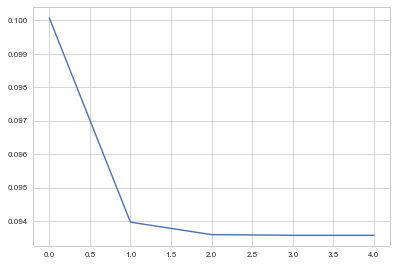

In [611]:
plot(pd.DataFrame(summary['iterations'])['cost'])

In [612]:
from park_martin import calibrate as park_martin_calibration
R,t = park_martin_calibration(A,B)
T = np.eye(4)
T[:3,:3] = R
T[:3,3] = t
matrix_to_motor(T).matrix()

array([[ 0.1128, -0.9933, -0.0259,  0.0391],
       [-0.9935, -0.1122, -0.0213,  0.1005],
       [ 0.0182,  0.0281, -0.9994,  0.1484],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

In [613]:
vd = VDMotorEstimationSolver()
vd.add_dual_line_observations(As,Bs)
vd.solve().matrix()

array([[ 0.0985, -0.9951,  0.0071,  0.    ],
       [-0.9951, -0.0985, -0.0008,  0.    ],
       [ 0.0015, -0.007 , -1.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

In [614]:
def Skew(a):
        return np.array([[0, -a[2], a[1]],
                         [a[2], 0, -a[0]],
                         [-a[1], a[0], 0]])

In [615]:
Ds = []
for a, b in zip(As, Bs):
#     a_ = a.rot().biv().unit() * a.rot().log().norm()
#     b_ = b.rot().biv().unit() * b.rot().log().norm()
    a_ = a.rot().biv()
    b_ = b.rot().biv()
    D = np.zeros((3,4))
    D[:3,0] = np.array(b_ - a_)
    D[:3,1:4] = Skew(b_ + a_)
    Ds.append(D.copy())
Ds = np.array(Ds).reshape(-1,4)
[U, s, Vt] = np.linalg.svd(Ds)
v = Vt.T[:,-1].copy()
M = vsr.Vec(0,0,0).trs() * vsr.Rot(*v)
print(M.matrix())
print(Rpm)

AttributeError: 'versor_pybind11.Dll' object has no attribute 'rot'

In [616]:
R = (vsr.Biv(1,2,3).unit() * (-pi/6)).exp()
print(R)
As = [vsr.Vec(1,0,0).duale(), vsr.Vec(0,1,0).duale(), vsr.Vec(0,0,1).duale()]
Bs = [a.spin(R) for a in As]

Ds = np.zeros((4,4))
# Ds = []
for a, b in zip(As, Bs):
    a_ = a
    b_ = b
    D = np.zeros((3,4))
    D[:3,0] = np.array(b_ - a_)
    D[:3,1:4] = Skew(b_ + a_)
    Ds += np.dot(D.T,D)
#     Ds.append(D.copy())
    
Ds = np.array(Ds).reshape(-1,4)
[U, s, Vt] = np.linalg.svd(Ds)
v = Vt.T[:,-1].copy()
M = vsr.Vec(0,0,0).trs() * vsr.Rot(*v)
print(M)

Rot: [ 0.87 0.13 0.27 0.4 ]
Mot: [ -0.87 0.13 0.27 0.4 0 0 0 0 ]


In [617]:
Vt.T

array([[-0.5   , -0.    ,  0.    , -0.866 ],
       [-0.2315,  0.5963, -0.757 ,  0.1336],
       [-0.4629, -0.7454, -0.3984,  0.2673],
       [-0.6944,  0.2981,  0.5179,  0.4009]])

In [618]:
   
Ds = []
for LA, LB in zip(LAs, LBs):
    D = np.zeros((3,8))
    a_ = LA.biv()
    ap_ = LA.drv().vec().unduale()
    b_ = LB.biv()
    bp_ = LB.drv().vec().unduale()
    D[:3,0] = np.array(b_ - a_)
    D[:3,1:4] = Skew(b_ + a_)
    Ds.append(D[1:4,:].copy())

NameError: name 'LAs' is not defined

In [619]:
(vsr.Vec(0,0,0).trs() * vsr.Biv(*(log(Rpm) * -0.5)).exp()).matrix()

array([[-0.9994,  0.0213, -0.0259,  0.    ],
       [-0.0281, -0.1122,  0.9933,  0.    ],
       [ 0.0182,  0.9935,  0.1128,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

In [620]:
Rpm

array([[ 0.1128, -0.9933, -0.0259],
       [-0.9935, -0.1122, -0.0213],
       [ 0.0182,  0.0281, -0.9994]])

In [621]:
Rpm = np.array([[ 0.11277704, -0.99328245, -0.02590984],
       [-0.99345287, -0.11224098, -0.02129233],
       [ 0.01824115,  0.02814149, -0.9994375 ]])
tpm = np.array([0.03907, 0.10054, 0.14837])

In [622]:
a = vsr.Vec(1,2,3)
a1 = vsr.CGA((a.trs() * vsr.Rot(1,0,0,0))).spin(vsr.CGA(M_eye_in_hand))
a1

CGA: [ 1 0 0 0 0 0 0 6.9e-18 0 0 0 0 -0.46 -0.27 -1.8 0 0 0 0 0 0 0 0 0 0 0 0 1.1e-16 0 0 0 0 ]

In [623]:
def daniilidis_motor(LAs, LBs):
    Ds = []
    for LA, LB in zip(LAs, LBs):
        D = np.zeros((8,8))
        for i in range(8):
            ei = vsr.Mot(0,0,0,0,0,0,0,0)
            ei[i] = 1.0
            D[:,i] = np.array(ei * LA - LB * ei)
        Ds.append(D[1:7,:].copy())

In [624]:
M = vsr.CGA(M_eye_in_hand)
M

CGA: [ 0.94 0 0 0 0 0 -0.2 0.067 -0.27 0 0 0 0.077 0.044 -0.16 0 0 0 0 0 0 0 0 0 0 0 0 0.01 0 0 0 0 ]

In [625]:
inf = vsr.CGA(*[0]*32); inf[5] = 1.0; print(inf)

CGA: [ 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ]


In [628]:
def estimate_motors_lars(dataset, noisy=False):
    
    def solve(L):
        Lrr = L[:4, :4]
        Lrq = L[:4, 4:]
        Lqr = L[4:, :4]
        Lqq = L[4:, 4:]
        Lp = Lrr - np.dot(Lrq, np.dot(np.linalg.pinv(Lqq), Lqr))
        w, v = np.linalg.eig(Lp)
        r = v[:, np.argmin(w)]
        q = np.dot(-np.dot(np.linalg.pinv(Lqq), Lqr), r)
        return vsr.Mot(*np.array([r, q]).ravel())

    Q = np.zeros((8,8))
        
    points_a = []
    points_b = []
    points_bn = []
    for (a,b,bn) in points:
        points_a.append(vsr.CGA(a))
        points_b.append(vsr.CGA(b))
        points_bn.append(vsr.CGA(bn))
        
    if noisy:
        for a,b in zip(points_a, points_bn):
            D = np.zeros((32,8))
            for i in range(8):
                ei = vsr.Mot(0,0,0,0,0,0,0,0)
                ei[i] = 1.0
                ei = vsr.CGA(ei)
                D[:,i] = np.array(a * ei - ei * b)
            Q += np.dot(D.T,D)
    else:
        for a,b in zip(points_a, points_b):
            D = np.zeros((32,8))
            for i in range(8):
                ei = vsr.Mot(0,0,0,0,0,0,0,0)
                ei[i] = 1.0
                ei = vsr.CGA(ei)
                D[:,i] = np.array(ei * b * ei.rev() * a -  a * ei * b * ei.rev())
            Q += np.dot(D.T,D)

    estimated_motor = solve(Q)
    
    return (converged, (points, motor, estimated_motor, _))

In [633]:
M = vsr.CGA((vsr.Dll(vsr.Vec(48,1,1).null(), vsr.Vec(1,3,1))*(pi/6)).exp())

T = vsr.Vec(-0.2,0.4,0.1).trs()
R = (vsr.Biv(1,-1,20).unit() * (pi/4)).exp()
M = T * R
M = vsr.CGA(M)

# As = [vsr.CGA(vsr.Vec(1,0,0).null()),
#       vsr.CGA(vsr.Vec(0,1,0).null()),
#       vsr.CGA(vsr.Vec(0,0,1).null())]
# Bs = [a.spin(M) for a in As]

As = [vsr.CGA(vsr.Vec(1,0,0).null()),
      vsr.CGA(vsr.Dll(vsr.Vec(48,1,1).null(), vsr.Vec(1,3,1))),
      vsr.CGA(vsr.Dlp(1,0,0,9)),
      vsr.CGA(vsr.Vec(1,2,3).trs() * vsr.Rot(vsr.Biv(1,5,-1).unit() * 0.87))]
Bs = [a.spin(M) for a in As]


# Bsn = [b.spin(vsr.CGA(vsr.Vec(0.01, 0.001, 0.001).trs() * vsr.Rot(vsr.Biv(1,2,3).unit() * 0.001))) for b in Bs] 

# Q = []

# n_lines = 10
# lines_a, lines_b = hand_eye_pose_pairs(M_object_in_world, M.mot(), n_lines)
# As = [vsr.CGA(a) for a in lines_a]
# Bs = [vsr.CGA(b) for b in lines_b]
def solve(L):
    Lrr = L[:4, :4]
    Lrq = L[:4, 4:]
    Lqr = L[4:, :4]
    Lqq = L[4:, 4:]
    Lp = Lrr - np.dot(Lrq, np.dot(np.linalg.pinv(Lqq), Lqr))
    w, v = np.linalg.eig(Lp)
    r = v[:, np.argmin(w)]
    q = np.dot(-np.dot(np.linalg.pinv(Lqq), Lqr), r)
    return vsr.Mot(*np.array([r, q]).ravel())

Q = np.zeros((8,8))
for b, a in zip(As[:], Bs[:]):
    D = np.zeros((32,8))
    for i in range(8):
        ei = vsr.Mot(0,0,0,0,0,0,0,0)
        ei[i] = 1.0
        ei = vsr.CGA(ei)
        D[:,i] = np.array(a * ei - ei * b)
        
    print(D)
    Q += np.dot(D.T,D)
    
M_est = solve(Q)
print(M_est)
print(M.mot())
print(M.mot() * M_est.rev())
    
# Q = np.array(Q).reshape(-1,8)
# U, s, Vt = np.linalg.svd(Q)
# M_est = vsr.Mot(*Vt.T[-1]).retract()
# print(M_est)
# print(M.mot())
# print(np.array(M.mot()))


[[ 0.      0.      0.      0.      0.      0.      0.      0.    ]
 [-0.205  -0.4996 -0.0999 -0.      2.      0.      0.      0.    ]
 [ 0.4996  1.795   0.     -0.0999  0.      2.      0.      0.    ]
 [ 0.0999 -0.      1.795   0.4996  0.      0.      2.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.    ]
 [-0.0542 -0.      0.     -0.      1.795   0.4996  0.0999 -0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0. 

In [582]:
Lrr = Q[:4, :4]
U, s, Vt = np.linalg.svd(Lrr)
R_est = vsr.Rot(*Vt.T[-1])
R_est

Rot: [ -0.64 -0.3 -0.031 0.71 ]

In [583]:
def solve(L):
    Lrr = L[:4, :4]
    Lrq = L[:4, 4:]
    Lqr = L[4:, :4]
    Lqq = L[4:, 4:]
    Lp = Lrr - np.dot(Lrq, np.dot(np.linalg.pinv(Lqq), Lqr))
    w, v = np.linalg.eig(Lp)
    r = v[:, np.argmin(w)]
    q = np.dot(-np.dot(np.linalg.pinv(Lqq), Lqr), r)
    return vsr.Mot(*np.array([r, q]).ravel())

In [584]:
solve(Q).rev()*-1

Mot: [ 0.71 0.035 -0.035 0.71 -0.065 0.18 -0.11 -0.062 ]

In [585]:
a = vsr.Vec(1,2,3).null()
b = vsr.Vec(4,5,6).null()
c = a - b

In [586]:
np.inner(c,c)

1019.25

In [587]:
av = a.vec()
bv = b.vec()
cv = av - bv

In [588]:
np.inner(cv, cv) + 0.25 * (np.inner(av, av) - np.inner(bv,bv))**2

1019.25

In [589]:
R = (vsr.Biv(1,2,3).unit() * (pi/6)).exp()
T = vsr.Vec(0,1,4).trs()

In [590]:
M = T * R
Mr = R.rev() * T
a = vsr.Mot(1,0,0,0,1,2,3,0)
vsr.CGA(M) * vsr.CGA(a) * vsr.CGA(Mr)

CGA: [ 1 0 0 0 0 0 0 6.9e-18 0 0 0 0 -1.1 -2 -0.58 0 0 0 0 0 0 0 0 0 0 0 0 -1.5e-16 0 0 0 0 ]

In [591]:
vsr.Vec(1,2,3).null().spin(T*R)

Dls: [ -1.137 0.005503 7.423 1 28.2 ]